# Setup

In [1]:
import pandas as pd
import numpy as np
# wizualizacje
import seaborn as sns
import matplotlib.pyplot as plt
# statystyki
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from patsy import dmatrices

# ustawienie szerokiego ekranu wyświetlacza JNotebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# opcje wyświetlania w Pandas
# - maks. 55 kolumn
# - maks. 101 wierszy
# - liczby w notacji dziesiętnej z czterema zerami po przecinku
pd.set_option('display.max_columns', 55)
pd.set_option('display.max_rows', 101)
pd.set_option('display.float_format', lambda x: f"{x:.4f}")

# opcje formatowania wykresów matplotlib
# - etykiety osi: bold
# - tekst: bold
# - domyślny rozmiar fontu=14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = '14'

# Wczytanie danych

In [2]:
# Zadanie 3
filepath = r"C:\Users\pnaumczyk\Documents\Dane\Python_modelowanie_crashCourse\train.csv"
df = (
    pd.read_csv(filepath, sep=';')
    
    .assign(
        **{
             k: lambda df_, col = k: pd.to_datetime(df_[col])
                for k in [
                    'Kiedy jechał*ś?'
                ]
        },
        **{ k: lambda df_, col = k: pd.to_numeric(df_[col], downcast='float')
                for k in [
                    'Koszt podróży:'
                ]
        },
        **{ k: lambda df_, col = k: pd.to_numeric(df_[col], downcast='integer')
                for k in [
                    'Liczba minut opóźnienia na starcie:', 'Liczba minut opóźnienia na mecie:'
                ]
        }
    )
    
    .astype({
        **{ k: 'string' 
               for k in [
                   'Stacja początkowa:', 'Stacja końcowa:', 'Jak wrażenia z podróży? :D (nieobowiązkowe)', 'Uwagi (nieobowiązkowe):'
               ]            
        },
        **{ k: 'category' 
               for k in [
                   'Rodzaj pociągu:', 'Pora dnia:'
               ]            
        }
    })
    
    .rename(columns={
        'Kiedy jechał*ś?'         : 'data_przejazdu',
        'Stacja początkowa:'      : 'stacja_start',
        'Stacja końcowa:'         : 'stacja_finisz',
        'Rodzaj pociągu:'         : 'rodzaj_pociagu',
        'Uwagi (nieobowiązkowe):' : 'uwagi',
        'Koszt podróży:'          : 'cena_biletu',
        'Pora dnia:'              : 'pora_dnia_przejazdu',
        'Liczba minut opóźnienia na starcie:' : 'opoznienie_start',
        'Liczba minut opóźnienia na mecie:'   : 'opoznienie_finisz',
        'Jak wrażenia z podróży? :D (nieobowiązkowe)' : 'wrazenia'
    })
    
    .drop(columns=['wrazenia', 'uwagi'])
    .drop(index=[30, 50])
    
    .assign(
        pora_dnia_przejazdu = lambda df_: np.select(
        [
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_start.str.contains('Legionowo')).astype(bool),
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_finisz.str.contains('Legionowo')).astype(bool),
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_finisz.str.contains('Gdask')).astype(bool)
        ],
        [
            'rano',
            'popołudnie',
            'popołudnie'            
        ],
        df_.pora_dnia_przejazdu
    ))
    
    .reset_index(drop=True)

#  ***************************************************************************************************
#  *************************** ZMIANA SPOSOBU WYLICZANIA SZKODY I WYPŁATY ****************************
#  ***************************************************************************************************
    
    
    .assign(
        czy_szkoda = lambda df_: np.select(
            [
                df_.opoznienie_finisz.gt(10) & df_.opoznienie_finisz.le(40),
                df_.opoznienie_finisz.gt(40)
            ],
            [
                1,
                2
            ],
            0
        ),
        
        wyplata_szkoda = lambda df_: np.where(
            df_.opoznienie_finisz.gt(10),
            df_.cena_biletu * np.exp(df_.opoznienie_finisz.div(100)) * df_.czy_szkoda,
            0.0
        )
    )
#  ***************************************************************************************************
#  ***************************************************************************************************
    
    .sort_values(by='data_przejazdu')
    .reset_index(drop=True)
)
df

,data_przejazdu,stacja_start,stacja_finisz,opoznienie_start,opoznienie_finisz,rodzaj_pociagu,cena_biletu,pora_dnia_przejazdu,czy_szkoda,wyplata_szkoda
0,2023-01-05,Warszawa Centralna,Gdańsk Oliwa,0,34,"""Zwykły"" InterCity",71.0000,popołudnie,1,99.7513
1,2023-01-10,Gdańsk Oliwa,Legionowo,0,10,"""Zwykły"" InterCity",71.0000,popołudnie,0,0.0000
2,2023-01-11,Legionowo Przystanek,Warszawa Centralna,0,3,Podmiejski / Regionalne,15.0000,rano,0,0.0000
3,2023-01-11,Warszawa Toruńska,Legionowo Przystanek,0,0,Podmiejski / Regionalne,15.0000,popołudnie,0,0.0000
4,2023-01-12,Warszawa Gdańska,Legionowo Przystanek,3,3,Podmiejski / Regionalne,15.0000,popołudnie,0,0.0000
...,...,...,...,...,...,...,...,...,...,...
98,2024-05-13,Gdańsk Oliwa,Warszawa Centralna,0,0,Pendolino,169.0000,rano,0,0.0000
99,2024-05-14,Warszawa Centralna,Gdańsk Oliwa,0,0,Pendolino,169.0000,popołudnie,0,0.0000
100,2024-05-21,Gdańsk Oliwa,Warszawa Centralna,26,38,Pendolino,169.0000,rano,1,247.1261
101,2024-05-23,Warszawa Centralna,Gdańsk Oliwa,0,0,"""Zwykły"" InterCity",71.0000,popołudnie,0,0.0000


# Spis treści
1. [Wykresy podstawowe w seaborn](#wykresy)
2. [Oznaczanie outlierów](#outliers)
3. [Podstawowe statystyki](#stats)
    1. [Różnice międzygrupowe](#group)
    2. [Miary związku](#corr)

***
***

# <a id='wykresy'>Wykresy podstawowe w seaborn</a> 
1. Wyświetl wykresy rozrzutu zmiennych ciągłych w układzie dwa wiersze po trzy kolumny każdy
2. Wyświetl histogramy rozkładu zmiennych ciągłych (z pominięciem daty przejazdu) w układzie jeden wiersz / pięć kolumn
3. Wyświetl wartości opóżnienń (na starcie i mecie) oraz wielkości wypłaty w zależności od dnia podróży (na jednym wykresie, posortowne datami)
4. Wyświetl wykresy pudełkowe pokazujące różnice w wypłaconym odszkodowaniu dla miast startu: Warszawa, Gdańsk, inne (każde miasto osobny wykres) oraz dla każdego typu pociągu (podział wewnątrz wykresu)
5. Wyświetl wykres punktowy pokazujący zależność między opóźnieniem na starcie, a opóźnieniem na mecie z poszczególnymi rodzajami pociągu zaznaczonymi odmiennymi kolorami z palety "viridis"
    1. Fancy - Wykonaj to samo, ale dorzuć na marginesach wykresy rozkładu zmiennych
    2. Fancy do kwadratu - wykonaj to samo (już bez podziału na typy pociągów), ale z wpisaną linią regresji związku między zmiennymi
    3. Fancy do sześcianu - wykonaj wykresy rozrzutu każdej zmiennej numerycznej z każdą z poszczególnymi rodzajami pociągu zaznaczonymi odmiennymi kolorami

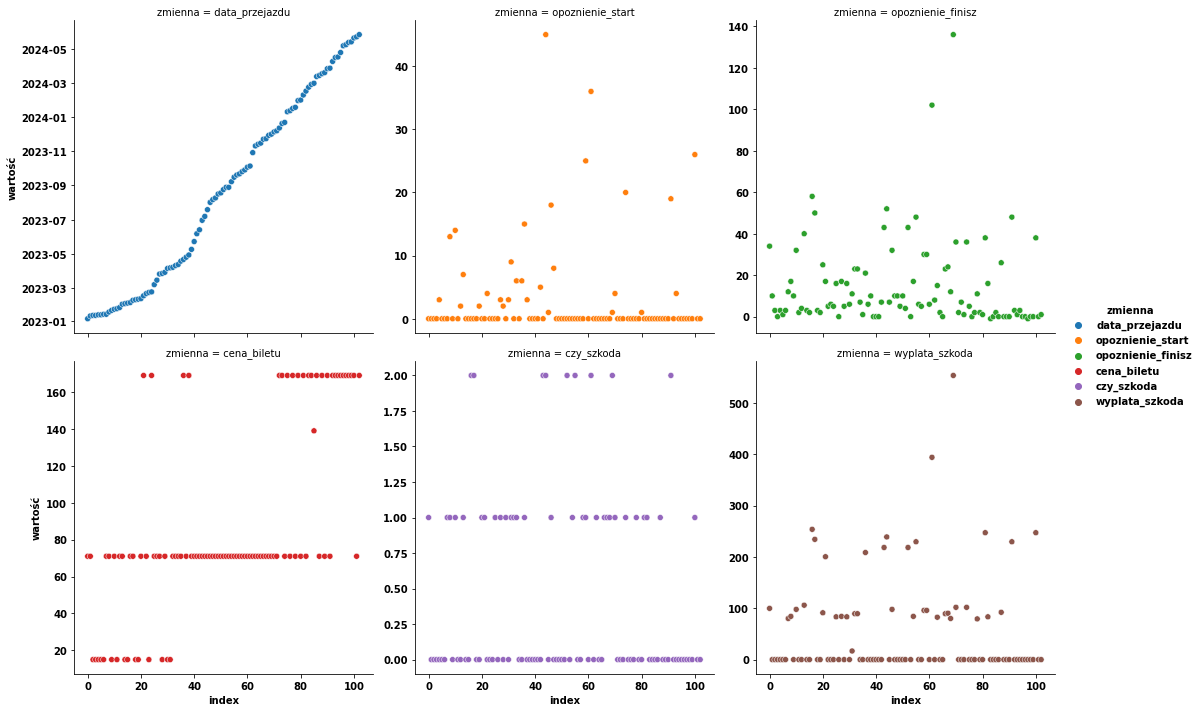

In [3]:
# Zadanie 1
df_vis = (
    df
    .select_dtypes(include=['number', 'datetime'])
    .reset_index()
    .pipe(lambda df_: pd.melt(
        df_,
        id_vars='index',
        value_vars=[
            'data_przejazdu', 'opoznienie_start', 'opoznienie_finisz', 
            'cena_biletu', 'czy_szkoda', 'wyplata_szkoda'
        ],
        var_name='zmienna',
        value_name='wartość'
    ))
)

g = sns.relplot(df_vis, x='index',y='wartość', col='zmienna', hue='zmienna', col_wrap=3, facet_kws={'sharey': False, 'sharex': True})

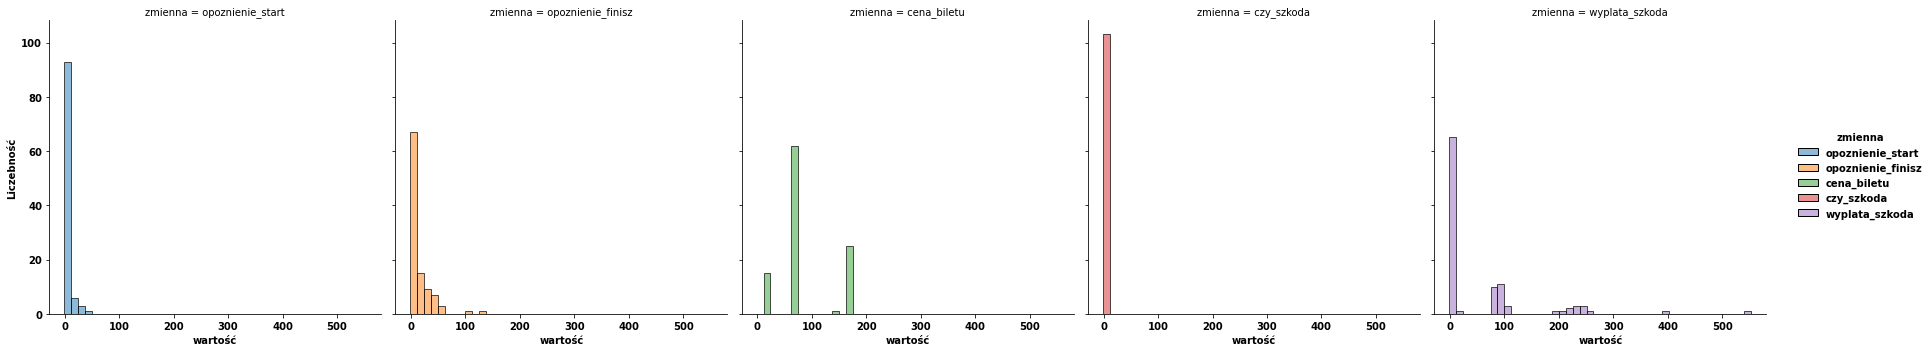

In [4]:
# Zadanie 2
df_vis = (
    df
    .select_dtypes(include=['number'])
    .reset_index()
    .pipe(lambda df_: pd.melt(
        df_,
        id_vars='index',
        value_vars=[
            'opoznienie_start', 'opoznienie_finisz', 
            'cena_biletu', 'czy_szkoda', 'wyplata_szkoda'
        ],
        var_name='zmienna',
        value_name='wartość'        
    ))
)

g = sns.displot(df_vis, x='wartość', col='zmienna', hue='zmienna')
g.set(ylabel="Liczebność")

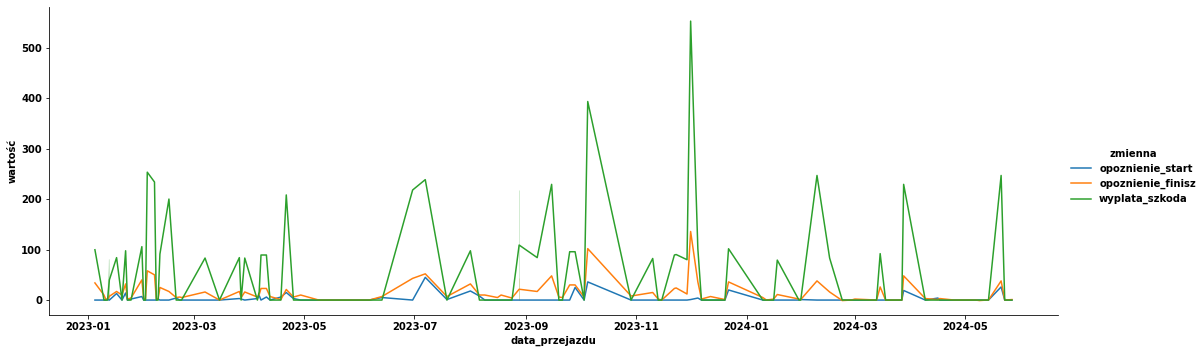

In [5]:
# Zadanie 3
cols = ['data_przejazdu', 'opoznienie_start', 'opoznienie_finisz', 'wyplata_szkoda']
df_vis = (
    df[cols]
    .pipe(lambda df_: pd.melt(
        df_,
        id_vars='data_przejazdu',
        value_vars=[
            'opoznienie_start', 'opoznienie_finisz', 'wyplata_szkoda'
        ],
        var_name='zmienna',
        value_name='wartość'        
        
    ))
)

g = sns.relplot(df_vis, x='data_przejazdu', y='wartość', hue='zmienna', kind='line', aspect=3)

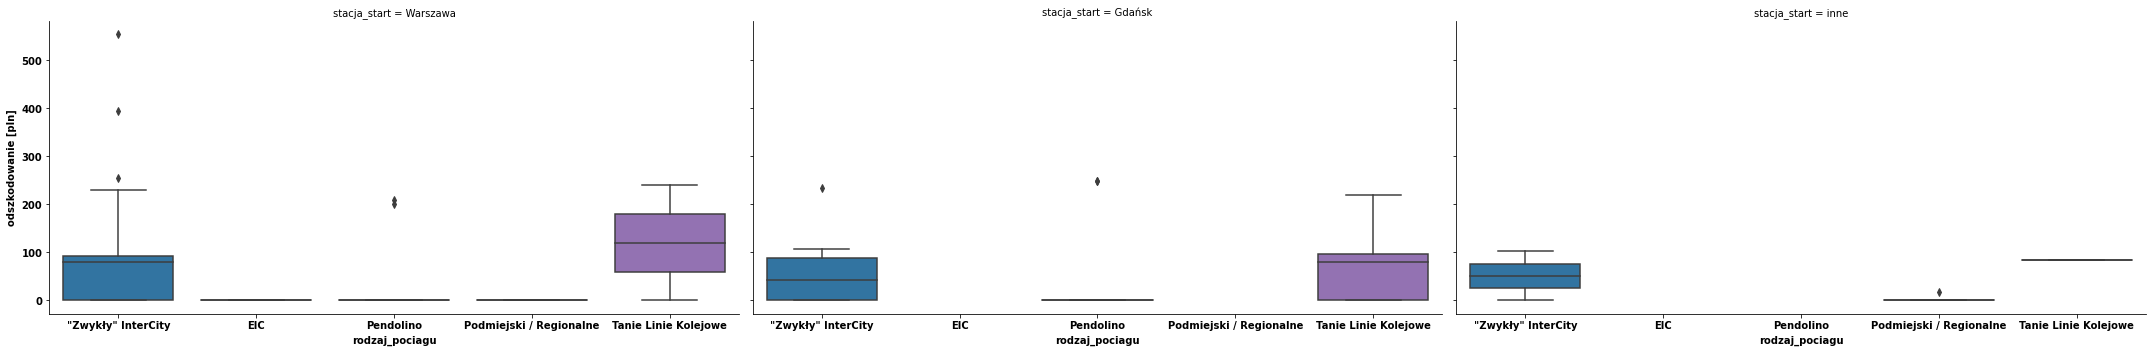

In [6]:
# Zadanie 4
cols = ['wyplata_szkoda', 'stacja_start', 'rodzaj_pociagu']
df_vis = (
    df[cols]
    .assign(
        stacja_start = lambda df_: np.select(
            [
                df_.stacja_start.str.contains("Warszawa").astype(bool),
                df_.stacja_start.str.contains("Gdańsk").astype(bool)
            ],
            [
                "Warszawa",
                "Gdańsk"
            ],
            "inne"
        )
    )
    .pipe(lambda df_: pd.melt(
        df_,
        id_vars= ['rodzaj_pociagu', 'stacja_start'],
        value_vars=['wyplata_szkoda'],
        value_name='odszkodowanie [pln]'        
        
    ))
)
# df_vis
g = sns.catplot(df_vis, x='rodzaj_pociagu', y='odszkodowanie [pln]', col='stacja_start',  kind='box', aspect=2)

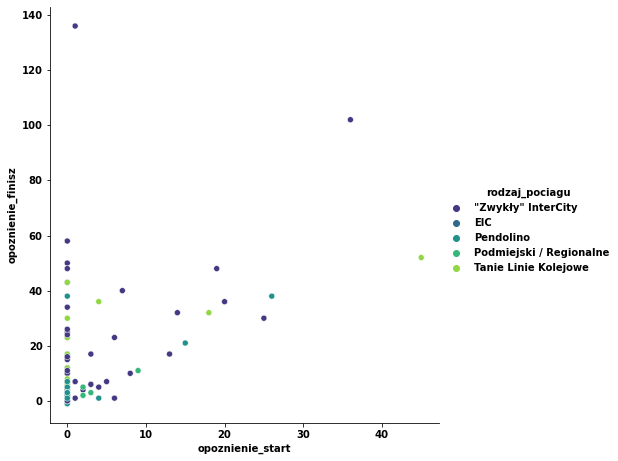

In [7]:
# Zadanie 5
g = sns.relplot(df, x='opoznienie_start', y='opoznienie_finisz', hue='rodzaj_pociagu', palette='viridis', height=6.5)

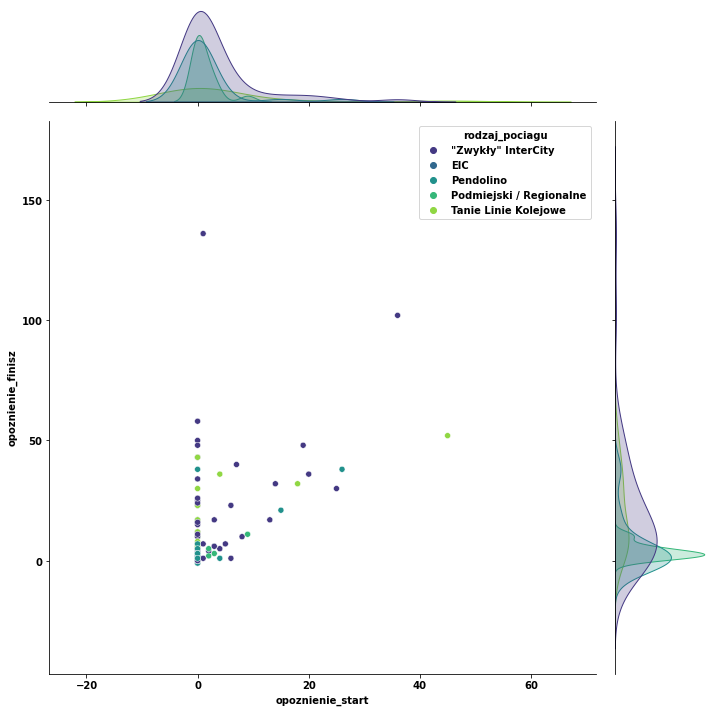

In [8]:
# Zadanie 5A - fancy
g = sns.jointplot(df, x='opoznienie_start', y='opoznienie_finisz', hue='rodzaj_pociagu', palette='viridis', height=10)

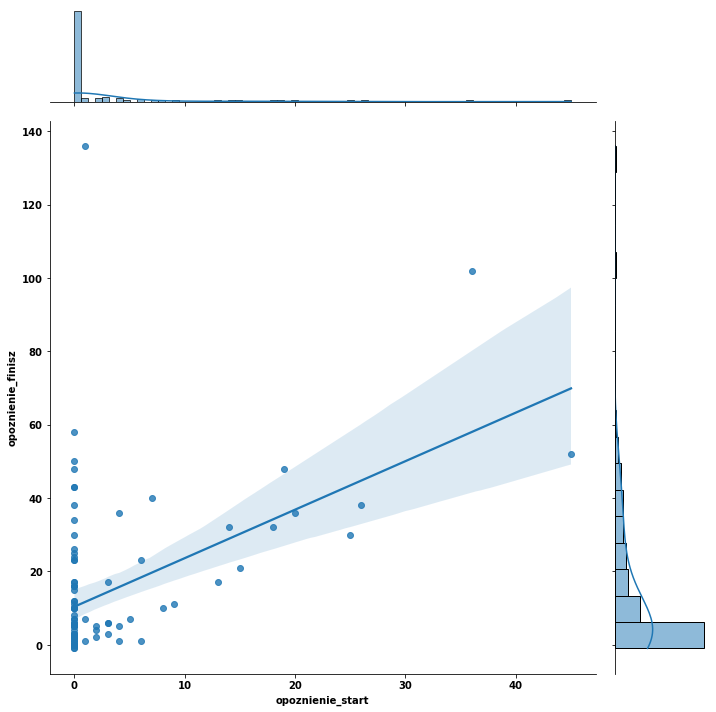

In [9]:
# Zadanie 5B - fancy do kwadratu
g = sns.jointplot(df, x='opoznienie_start', y='opoznienie_finisz', kind='reg', height=10)

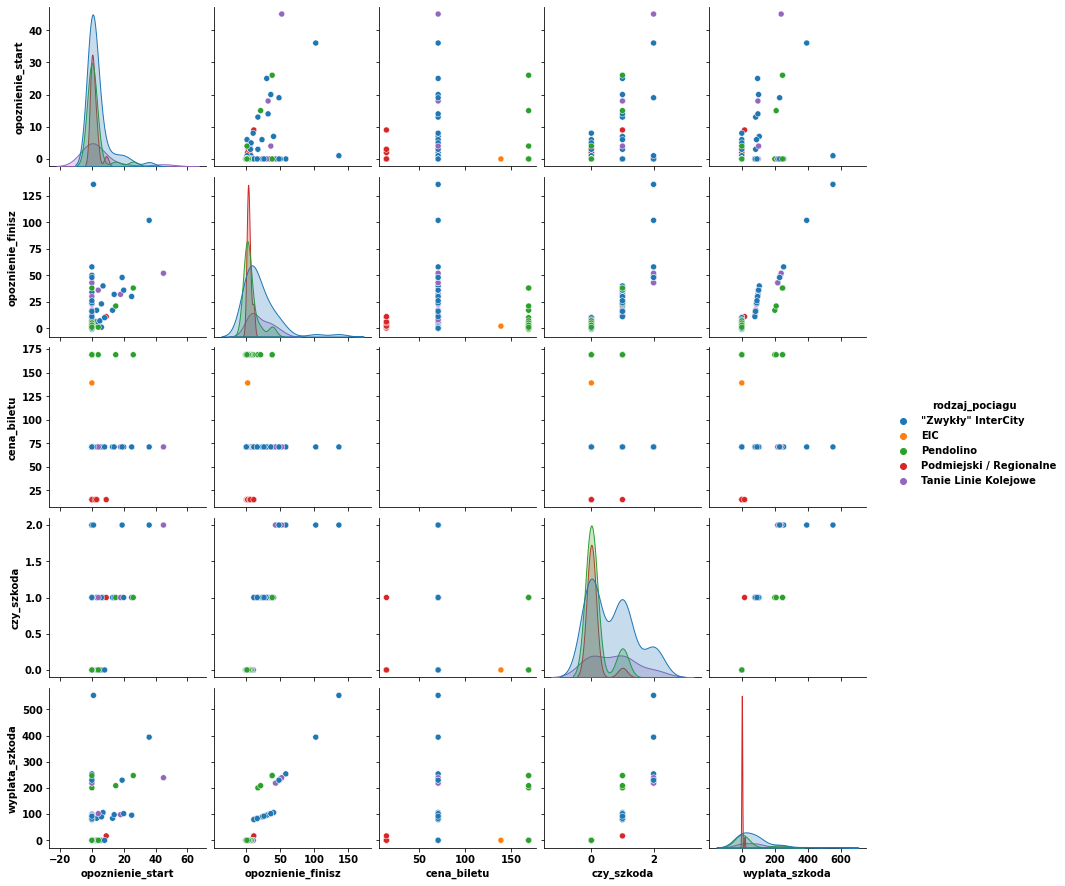

In [10]:
# Zadanie 5C - fancy do sześcianu
g = sns.pairplot(df, hue='rodzaj_pociagu')

# <a id='outliers'>Oznaczanie outlierów</a>


Outliery zmiennych wyjaśniających:



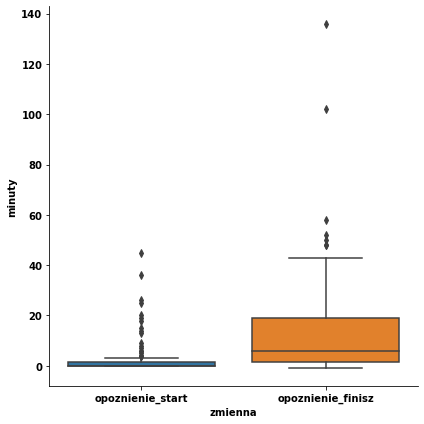

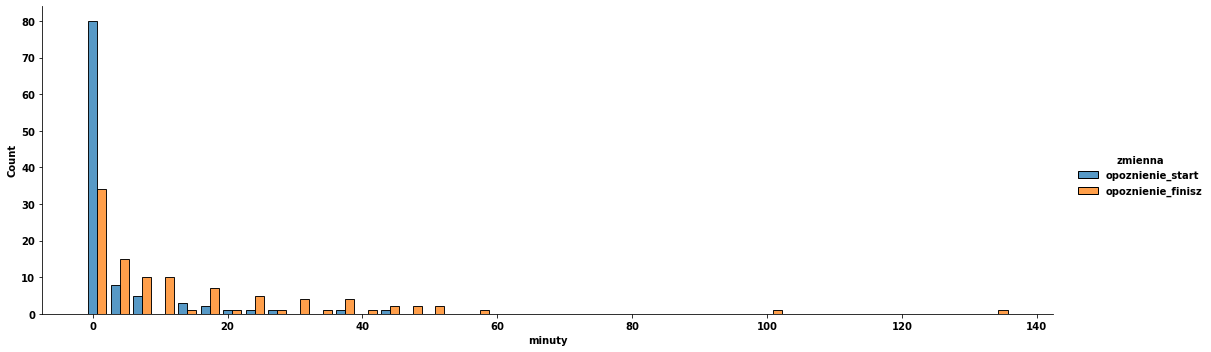


Outliery zmiennych wyjaśnianych:



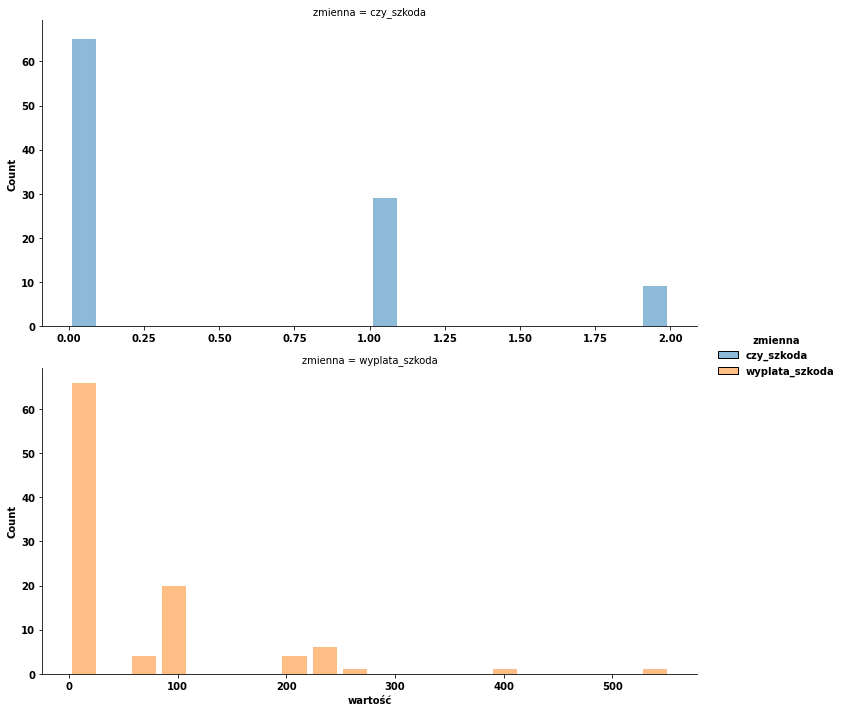

In [11]:
# Mamy dwie zmienne ciągłe - warto sprawdzić obie
df_vis = (
    df[['opoznienie_start', 'opoznienie_finisz']]
    .reset_index()
    .pipe(lambda df_: pd.melt(
        df_,
        id_vars='index',
        value_vars=[
            'opoznienie_start', 'opoznienie_finisz' 
        ],
        var_name='zmienna',
        value_name='minuty'        
        
    ))
)
print(f"\nOutliery zmiennych wyjaśniających:\n")

g=sns.catplot(df_vis, x='zmienna', y='minuty', kind='box',  height=6)
plt.show()
f=sns.displot(df_vis, x='minuty', hue='zmienna', aspect=3, multiple='dodge', shrink=0.8)
plt.show()
# Zmienne są skośne, tylko jedną znich możemy użyć do modelowania (start) i tutaj bym outlierów nie wycinała w pierwszym obrocie modelu, 
# ewentualnie przycięła do 95% jeśli byłaby konieczna reiteracja

# Przyjrzyjmy się też outlierom w zmiennych wyjaśnianych
print(f"\nOutliery zmiennych wyjaśnianych:\n")
df_vis1 = (
    df[['czy_szkoda', 'wyplata_szkoda']]
    .reset_index()
    .pipe(lambda df_: pd.melt(
        df_,
        id_vars='index',
        value_vars=[
            'czy_szkoda', 'wyplata_szkoda'
        ],
        var_name='zmienna',
        value_name='wartość'        
        
    ))
)
h=sns.displot(df_vis1, x='wartość', row='zmienna', hue='zmienna', aspect=2, shrink=0.8, bins=20, common_bins=False, facet_kws={'sharex':False})
plt.show()
# Tutaj też nie czyściłabym outlierów

# <a id='stats'>Podstawowe statystyki</a>
## <a id='group'>Różnice międzygrupowe</a>
Zbadaj poniższe odwołując się do adekwatnych statystyk<br>
1. Czy pociągi jeżdżące o różnych porach dnia istotnie różnią się opóźnieniem na mecie?
2. Czy jest istotna różnica między opóźnieniem na mecie pociągów jeżdżących z Gdańska vs z Warszawy vs z innych lokalizacji?
3. Czy jest istotna różnica w liczbie szkód w zależności czy pociąg jechał rano, czy wieczorem?

Sprawdzam liczebności grup: 


,pora_dnia_przejazdu
popołudnie,64
rano,39




SPRAWDZENIE NORMALNOŚCI ROZKŁADÓW
Liczebności są na granicy pomiędzy tymi wymaganymi dla testu Shapiro-Wilka i Kołmogorowa-Smirnofa 
Dla celów dydaktycznych sprawdzam oba:

Shapiro-Wilk:
Dla pociągów popołudniowych: ShapiroResult(statistic=0.7123278379440308, pvalue=6.763075099947002e-10)
Dla pociągów porannych: ShapiroResult(statistic=0.6827883720397949, pvalue=6.721531775610856e-08)

Kolmogorov-Smirnov:
Dla pociągów popołudniowych: KstestResult(statistic=0.7272498680518208, pvalue=5.253466550036304e-35)
Dla pociągów porannych: KstestResult(statistic=0.7208396116415644, pvalue=4.379964294861199e-21)

Wyniki testów sugerują rozkłady nienormalne w porównywanych grupach. Należy więc użyć testów nieparametrycznych.
Potwierdzenie "organoleptyczne":


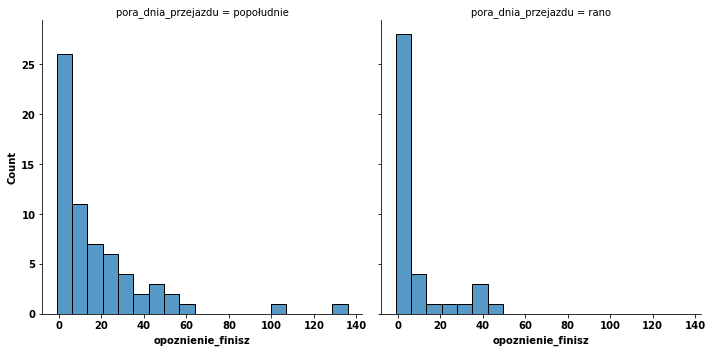



PORÓWNANIE ISTOTNOŚCI RÓŻNICY TESTEM U MANNA-WHITNEYA
Statystyki opisowe:



,count,mean,std,min,25%,50%,75%,max
pora_dnia_przejazdu,,,,,,,,
popołudnie,64.0000,17.7969,24.2541,-1.0000,1.7500,10.0000,24.2500,136.0000
rano,39.0000,8.5641,12.1131,0.0000,1.5000,3.0000,8.5000,43.0000



U Mann-Whitney:
Two-sided: MannwhitneyuResult(statistic=965.5, pvalue=0.05434469774327064)
One-sided: MannwhitneyuResult(statistic=965.5, pvalue=0.02717234887163532)

Effect size: 0.226

WNIOSEK:
POCIĄGI JEŻDŻĄCE PO POŁUDNIU SPÓŹNIAJĄ SIĘ BARDZIEJ


In [12]:
# Zadanie 1
print(
    f"Sprawdzam liczebności grup: "
)
display(df.pora_dnia_przejazdu.value_counts().to_frame())
print(    
    f"\n\nSPRAWDZENIE NORMALNOŚCI ROZKŁADÓW\n"
    f"Liczebności są na granicy pomiędzy tymi wymaganymi dla testu Shapiro-Wilka i Kołmogorowa-Smirnofa \n"
    f"Dla celów dydaktycznych sprawdzam oba:\n\n"
    f"Shapiro-Wilk:\n"
    f"Dla pociągów popołudniowych: {stats.shapiro(df.loc[df.pora_dnia_przejazdu.eq('popołudnie'), 'opoznienie_finisz'].values)}\n"
    f"Dla pociągów porannych: {stats.shapiro(df.loc[df.pora_dnia_przejazdu.eq('rano'), 'opoznienie_finisz'].values)}\n\n"
    f"Kolmogorov-Smirnov:\n"
    f"Dla pociągów popołudniowych: {stats.ks_1samp(df.loc[df.pora_dnia_przejazdu.eq('popołudnie'), 'opoznienie_finisz'].values, stats.norm.cdf)}\n"
    f"Dla pociągów porannych: {stats.ks_1samp(df.loc[df.pora_dnia_przejazdu.eq('rano'), 'opoznienie_finisz'].values, stats.norm.cdf)}\n\n"
    f"Wyniki testów sugerują rozkłady nienormalne w porównywanych grupach. Należy więc użyć testów nieparametrycznych.\n"
    f"Potwierdzenie \"organoleptyczne\":"
)

sns.displot(df, x='opoznienie_finisz', col='pora_dnia_przejazdu')
plt.show()
print(
    f"\n\nPORÓWNANIE ISTOTNOŚCI RÓŻNICY TESTEM U MANNA-WHITNEYA\n"
    f"Statystyki opisowe:\n"
)
display(df.groupby(by='pora_dnia_przejazdu')['opoznienie_finisz'].describe())
print(
    f"\nU Mann-Whitney:\n"
    f"Two-sided: {stats.mannwhitneyu(df.loc[df.pora_dnia_przejazdu.eq('rano'), 'opoznienie_finisz'].values, df.loc[df.pora_dnia_przejazdu.eq('popołudnie'), 'opoznienie_finisz'].values)}\n"
    f"One-sided: {stats.mannwhitneyu(df.loc[df.pora_dnia_przejazdu.eq('rano'), 'opoznienie_finisz'].values, df.loc[df.pora_dnia_przejazdu.eq('popołudnie'), 'opoznienie_finisz'].values, alternative='less')}\n"
)

eff_size = 1-((2* stats.mannwhitneyu(df.loc[df.pora_dnia_przejazdu.eq('rano'), 'opoznienie_finisz'].values, df.loc[df.pora_dnia_przejazdu.eq('popołudnie'), 'opoznienie_finisz'].values)[0])/(df.pora_dnia_przejazdu.value_counts()[0] * df.pora_dnia_przejazdu.value_counts()[1]))

print(
    f"Effect size: {eff_size:.3}\n"
    f"\nWNIOSEK:\n"
    f"POCIĄGI JEŻDŻĄCE PO POŁUDNIU SPÓŹNIAJĄ SIĘ BARDZIEJ"
)


Sprawdzam liczebności grup: 


,stacja_start
Warszawa,46
Gdańsk,41
inne,16



Różnica "organoleptycznie":



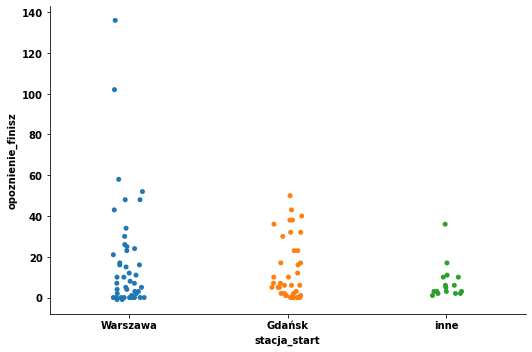


SPRAWDZENIE JEDNORODNOŚCI WARIANCJI W BADANYCH GRUPACH
Test Levene'a:
Test: LeveneResult(statistic=2.392424043144404, pvalue=0.09662190478628234)
Możemy przyjąć, ze wariancje są równe. Stąd korzystamy z testu parametrycznego

JEDNOCZYNNIKOWA ANALIZA WARIANCJI
Statystyki opisowe:




,N,Mean,SD,SE,95% Conf.,Interval
stacja_start,,,,,,
Gdańsk,41,12.8537,14.8737,2.3229,8.1589,17.5484
Warszawa,46,17.9565,27.1866,4.0084,9.8831,26.0299
inne,16,7.5000,8.7636,2.1909,2.8302,12.1698




Kalkulacja jednoczynnikowej ANOVY wraz z effect size:



,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(stacja_start),1440.6349,2.0000,720.3175,1.6650,0.1944,0.0322,0.0127
Residual,43261.0350,100.0000,432.6103,NaN,NaN,NaN,NaN



WNIOSEK:
BRAK ISTOTNYCH RÓŻNIC W OSTATECZNYM OPÓŹNIENIU POMIĘDZY RÓŻNYMI STACJAMI STARTU PODRÓŻY


In [13]:
# Zadanie 2
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

cols = ['opoznienie_finisz', 'stacja_start']
df_vis = (
    df[cols]
    .assign(
        stacja_start = lambda df_: np.select(
            [
                df_.stacja_start.str.contains("Warszawa").astype(bool),
                df_.stacja_start.str.contains("Gdańsk").astype(bool)
            ],
            [
                "Warszawa",
                "Gdańsk"
            ],
            "inne"
        )
    )
)

print(
    f"Sprawdzam liczebności grup: "
)
display(df_vis.stacja_start.value_counts().to_frame())
print(
    f"\nRóżnica \"organoleptycznie\":\n"
)

sns.catplot(df_vis, x='stacja_start', y='opoznienie_finisz', hue='stacja_start', aspect=1.5)
plt.show()
print(
    f"\nSPRAWDZENIE JEDNORODNOŚCI WARIANCJI W BADANYCH GRUPACH\n"
    f"Test Levene'a:"
)

l = stats.levene(
    df_vis.loc[df_vis.stacja_start.eq('Warszawa'), 'opoznienie_finisz'], 
    df_vis.loc[df_vis.stacja_start.eq('Gdańsk'), 'opoznienie_finisz'], 
    df_vis.loc[df_vis.stacja_start.eq('inne'), 'opoznienie_finisz'],
    center='median'
)
print(
    f"Test: {l}\n"
    f"Możemy przyjąć, ze wariancje są równe. Stąd korzystamy z testu parametrycznego\n\n"
    f"JEDNOCZYNNIKOWA ANALIZA WARIANCJI\n"
    f"Statystyki opisowe:"
)
display(rp.summary_cont(df_vis.groupby(by='stacja_start')['opoznienie_finisz']))

print(
    f"\n\nKalkulacja jednoczynnikowej ANOVY wraz z effect size:\n"
)
model = smf.ols('opoznienie_finisz ~ C(stacja_start)', data=df_vis).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
display(anova_table(aov_table))
print(
    f"\nWNIOSEK:\n"
    f"BRAK ISTOTNYCH RÓŻNIC W OSTATECZNYM OPÓŹNIENIU POMIĘDZY RÓŻNYMI STACJAMI STARTU PODRÓŻY"    
)

Sprawdzam rozkład liczebności:


pora_dnia_przejazdu,popołudnie,rano
czy_szkoda,,
0,34,31
1,22,7
2,8,1



Różnica "organoleptycznie":



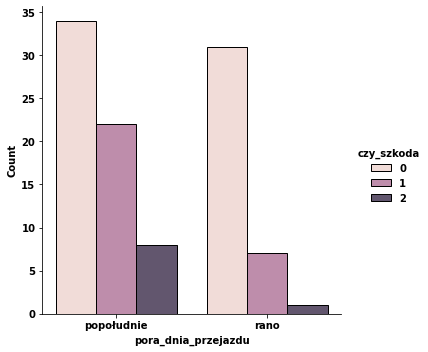

SPRAWDZENIE ISTOTNOŚCI ROZKŁADU CHI-KWADRAT
Oczekiwane wartości liczebności:


pora_dnia_przejazdu        
pora_dnia_przejazdu          popołudnie    rano
czy_szkoda                                     
0                               40.3883 24.6117
1                               18.0194 10.9806
2                                5.5922  3.4078

Statystyka i effect size:


,Chi-square test,results
0,Pearson Chi-square ( 2.0) =,7.7289
1,p-value =,0.0210
2,Cramer's V =,0.2739



WNIOSEK:
Są różnice w liczbie szkód między pociągami porannymi i popołudniowymi. Pociągi poranne są mniej szkodowe.


In [14]:
# Zadanie 3
print(
    f"Sprawdzam rozkład liczebności:"
)
ct = pd.crosstab(df.czy_szkoda, df.pora_dnia_przejazdu)
display(ct)
print(
    f"\nRóżnica \"organoleptycznie\":\n"
)

# df_vis = df[['czy_szkoda', 'pora_dnia_przejazdu']]

sns.displot(df, x='pora_dnia_przejazdu', hue='czy_szkoda', multiple='dodge', shrink=.8)
plt.show()

print(
    f"SPRAWDZENIE ISTOTNOŚCI ROZKŁADU CHI-KWADRAT"
)

ct, chi, ct_exp = rp.crosstab(
    df.czy_szkoda, 
    df.pora_dnia_przejazdu,
    test='chi-square',
    expected_freqs = True,
    prop='cell'
)
print(f"Oczekiwane wartości liczebności:")
display(ct_exp)
print(f"Statystyka i effect size:")
display(chi)

print(
    f"\nWNIOSEK:\n"
    f"Są różnice w liczbie szkód między pociągami porannymi i popołudniowymi. Pociągi poranne są mniej szkodowe."    
)


## <a id='corr'>Miary związku</a>
Zbadaj poniższe odwołując się do adekwatnych statystyk<br>
1. Jaki jest związek między zmiennymi wyjaśnianymi a wyjaśniającymi?
2. Jaki jest związek zmiennych wyjaśniających między sobą nawzajem?

In [15]:
# Zadanie 1


In [16]:
# Zadanie 2